# 整体建模

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

# 创建数据
data = {
    "Bandwidth_MB_s": [41.746, 62.982, 65.596, 101.968, 138.671, 159.773, 177.197, 190.415, 193.555, 194.056, 194.097,
                       193.776, 193.419, 193.679, 194.425, 194.462, 36.732, 55.592, 80.364, 100.85, 116.875, 133.242,
                       160.23, 178.519, 189.055, 193.55, 193.752, 193.717, 193.417, 193.686, 194.365, 194.416, 33.096,
                       48.456, 72.221, 97.357, 113.762, 125.266, 134.315, 164.453, 178.744, 187.352, 192.915, 193.512,
                       192.669, 193.47, 194.342, 194.218],
    "Cards": [64] * 16 + [128] * 16 + [256] * 16,
    "Data_MB": [512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304,
                8388608, 16777216] * 3
}

# 转换为DataFrame
df = pd.DataFrame(data)

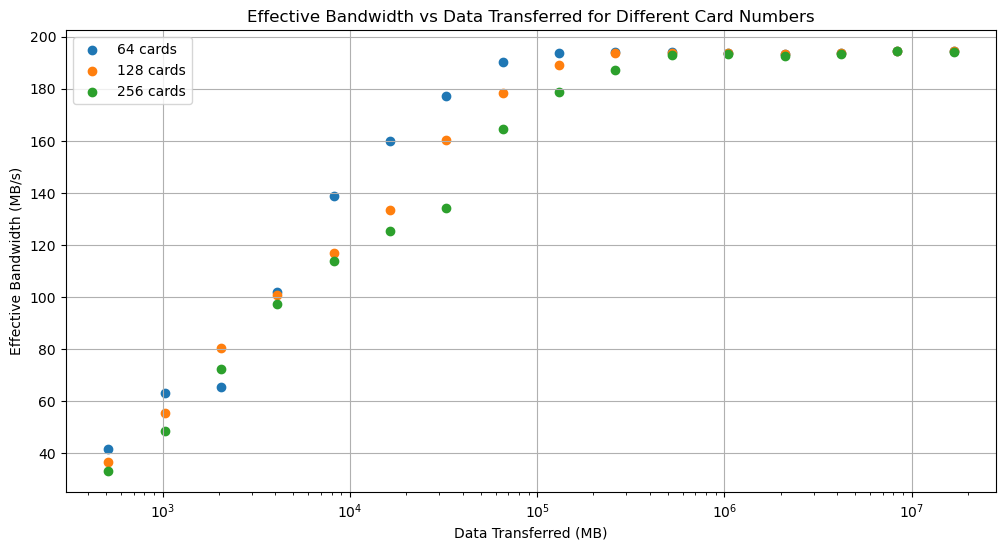

,Bandwidth_MB_s,Cards,Data_MB
0,41.746,64,512
1,62.982,64,1024
2,65.596,64,2048
3,101.968,64,4096
4,138.671,64,8192


In [2]:
# 可视化数据
plt.figure(figsize=(12, 6))
for card in df['Cards'].unique():
    subset = df[df['Cards'] == card]
    plt.scatter(subset['Data_MB'], subset['Bandwidth_MB_s'], label=f'{card} cards')

plt.xlabel('Data Transferred (MB)')
plt.ylabel('Effective Bandwidth (MB/s)')
plt.title('Effective Bandwidth vs Data Transferred for Different Card Numbers')
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.show()

# 显示前几行数据以验证
df.head()


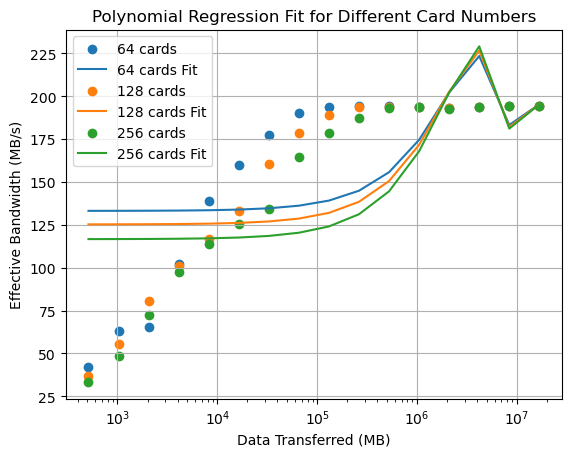

{64: 0.29521420726901804, 128: 0.37275935247217706, 256: 0.4423389359860739}

In [3]:

# 准备多项式回归模型
degree = 3  # 多项式的度数
poly_features = PolynomialFeatures(degree=degree, include_bias=False)

# 用于存储拟合结果和评分
models = {}
scores = {}

# 分别对每个卡数的数据进行拟合
for card in df['Cards'].unique():
    subset = df[df['Cards'] == card]

    # 准备数据
    X = subset['Data_MB'].values.reshape(-1, 1)
    y = subset['Bandwidth_MB_s'].values
    X_poly = poly_features.fit_transform(X)

    # 拟合模型
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)

    # 评估模型
    score = r2_score(y, y_pred)

    # 存储模型和评分
    models[card] = model
    scores[card] = score

    # 可视化拟合结果
    plt.scatter(X, y, label=f'{card} cards')
    plt.plot(X, y_pred, label=f'{card} cards Fit')

# 绘制图表
plt.xlabel('Data Transferred (MB)')
plt.ylabel('Effective Bandwidth (MB/s)')
plt.title('Polynomial Regression Fit for Different Card Numbers')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

# 输出评分
scores



# 分段建模

In [21]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

# 重新创建数据
data = {
    "Bandwidth_MB_s": [41.746, 62.982, 65.596, 101.968, 138.671, 159.773, 177.197, 190.415, 193.555, 194.056, 194.097,
                       193.776, 193.419, 193.679, 194.425, 194.462, 36.732, 55.592, 80.364, 100.85, 116.875, 133.242,
                       160.23, 178.519, 189.055, 193.55, 193.752, 193.717, 193.417, 193.686, 194.365, 194.416, 33.096,
                       48.456, 72.221, 97.357, 113.762, 125.266, 134.315, 164.453, 178.744, 187.352, 192.915, 193.512,
                       192.669, 193.47, 194.342, 194.218],
    "Cards": [64] * 16 + [128] * 16 + [256] * 16,
    "Data_MB": [512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304,
                8388608, 16777216] * 3
}

# 转换为DataFrame
df = pd.DataFrame(data)

# 定义分段
segments = {
    'small': (512, 32768),  # 512KB - 32MB
    'medium': (65536, 524288),  # 64MB - 512MB
    'large': (1048576, 16777216)  # 1GB - 16GB
}

# 用于存储拟合结果和评分
segment_scores = {seg: {} for seg in segments}

# 对每个分段和卡数的数据进行拟合
for seg, (low, high) in segments.items():
    for card in df['Cards'].unique():
        subset = df[(df['Cards'] == card) & (df['Data_MB'] >= low) & (df['Data_MB'] <= high)]

        # 如果该段中没有足够的数据点，则跳过
        if len(subset) < 2:
            continue

        # 准备数据
        X = subset['Data_MB'].values.reshape(-1, 1)
        y = subset['Bandwidth_MB_s'].values
        poly_features = PolynomialFeatures(degree=3, include_bias=False)
        X_poly = poly_features.fit_transform(X)

        # 拟合模型
        model = LinearRegression()
        model.fit(X_poly, y)
        y_pred = model.predict(X_poly)

        # 评估模型
        score = r2_score(y, y_pred)
        segment_scores[seg][card] = score

segment_scores
df



,Bandwidth_MB_s,Cards,Data_MB
0,41.746,64,512
1,62.982,64,1024
2,65.596,64,2048
3,101.968,64,4096
4,138.671,64,8192
5,159.773,64,16384
6,177.197,64,32768
7,190.415,64,65536
8,193.555,64,131072
9,194.056,64,262144


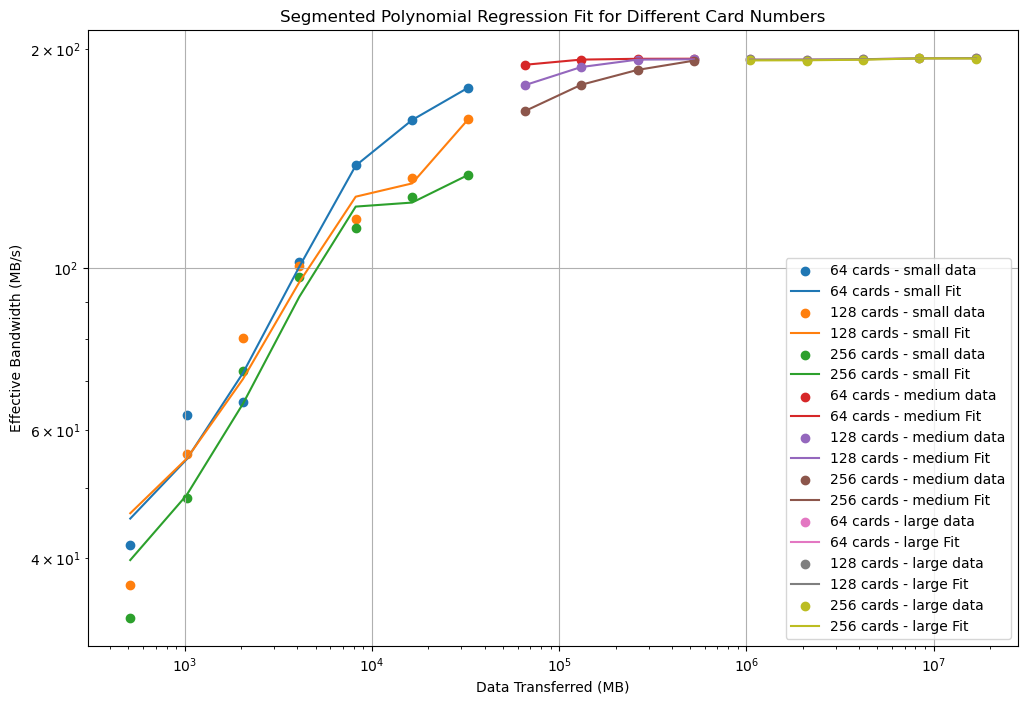

In [5]:
import matplotlib.pyplot as plt

# 可视化每个分段的拟合结果
plt.figure(figsize=(12, 8))

# 遍历每个分段和卡数，绘制拟合曲线
for seg, (low, high) in segments.items():
    for card in df['Cards'].unique():
        subset = df[(df['Cards'] == card) & (df['Data_MB'] >= low) & (df['Data_MB'] <= high)]

        # 如果该段中没有足够的数据点，则跳过
        if len(subset) < 2:
            continue

        # 准备数据
        X = subset['Data_MB'].values.reshape(-1, 1)
        y = subset['Bandwidth_MB_s'].values
        poly_features = PolynomialFeatures(degree=3, include_bias=False)
        X_poly = poly_features.fit_transform(X)

        # 从之前的模型中获取预测值
        model = LinearRegression().fit(X_poly, y)
        y_pred = model.predict(X_poly)

        # 绘制散点图和拟合曲线
        plt.scatter(X, y, label=f'{card} cards - {seg} data')
        plt.plot(X, y_pred, label=f'{card} cards - {seg} Fit')

# 设置图表
plt.xlabel('Data Transferred (MB)')
plt.ylabel('Effective Bandwidth (MB/s)')
plt.title('Segmented Polynomial Regression Fit for Different Card Numbers')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# 重新定义分段和拟合模型
segments = {
    'small': (512, 32768),
    'medium': (65536, 524288),
    'large': (1048576, 16777216)
}

# 存储模型
models = {seg: {card: None for card in df['Cards'].unique()} for seg in segments}

# 拟合每个分段的模型
for seg, (low, high) in segments.items():
    for card in df['Cards'].unique():
        subset = df[(df['Cards'] == card) & (df['Data_MB'] >= low) & (df['Data_MB'] <= high)]

        # 跳过数据点不足的情况
        if len(subset) < 2:
            continue

        X = subset['Data_MB'].values.reshape(-1, 1)
        y = subset['Bandwidth_MB_s'].values
        poly_features = PolynomialFeatures(degree=3, include_bias=False)
        X_poly = poly_features.fit_transform(X)

        model = LinearRegression().fit(X_poly, y)
        models[seg][card] = model

# 预测35 MB数据量下的有效带宽
data_volume = 150 * 1024  # 将35 MB转换为KB
predictions = {}

# 使用中等数据量段的模型进行预测
for card, model in models['medium'].items():
    if model:
        X_pred = poly_features.fit_transform([[data_volume]])
        predictions[card] = model.predict(X_pred)[0]

predictions



{64: 194.08858444743524, 128: 191.13862156648455, 256: 181.80805163155983}

In [20]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import joblib

# Path to your Excel file
excel_path = './performance_comm.xlsx'

# Read the Excel file
xls = pd.ExcelFile(excel_path)

# Iterate through each sheet
for sheet_name in xls.sheet_names:
    # Read sheet into DataFrame
    df = pd.read_excel(excel_path, sheet_name=sheet_name)

    data={
        'Data_MB':[]
    }
    # Assuming the first column is the target variable and the rest are features
    X = df.iloc[:, 1:]
    y = df.iloc[:, 0:5]
    print(X)



        512      1024      2048      4096      8192      16384      32768  \
0    41.746    62.982    65.596   101.968   138.671    159.773    177.197   
1    36.732    55.592    80.364   100.850   116.875    133.242    160.230   
2    33.096    48.456    72.221    97.357   113.762    125.266    134.315   
3    31.373    45.982    68.043    97.826   114.859    124.801    148.911   
4       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
5   512.000  1024.000  2048.000  4096.000  8192.000  16384.000  32768.000   
6    54.933    72.245   124.303   156.110   210.332    269.696    311.032   
7    49.792    78.400   128.243   181.232   214.842    254.310    253.433   
8    42.802    72.579   100.764   159.563   200.008    231.067    266.656   
9    37.939    62.313    73.708   137.406   184.352    222.583    244.404   
10      NaN       NaN       NaN       NaN       NaN        NaN        NaN   
11  512.000  1024.000  2048.000  4096.000  8192.000  16384.000  32768.000   

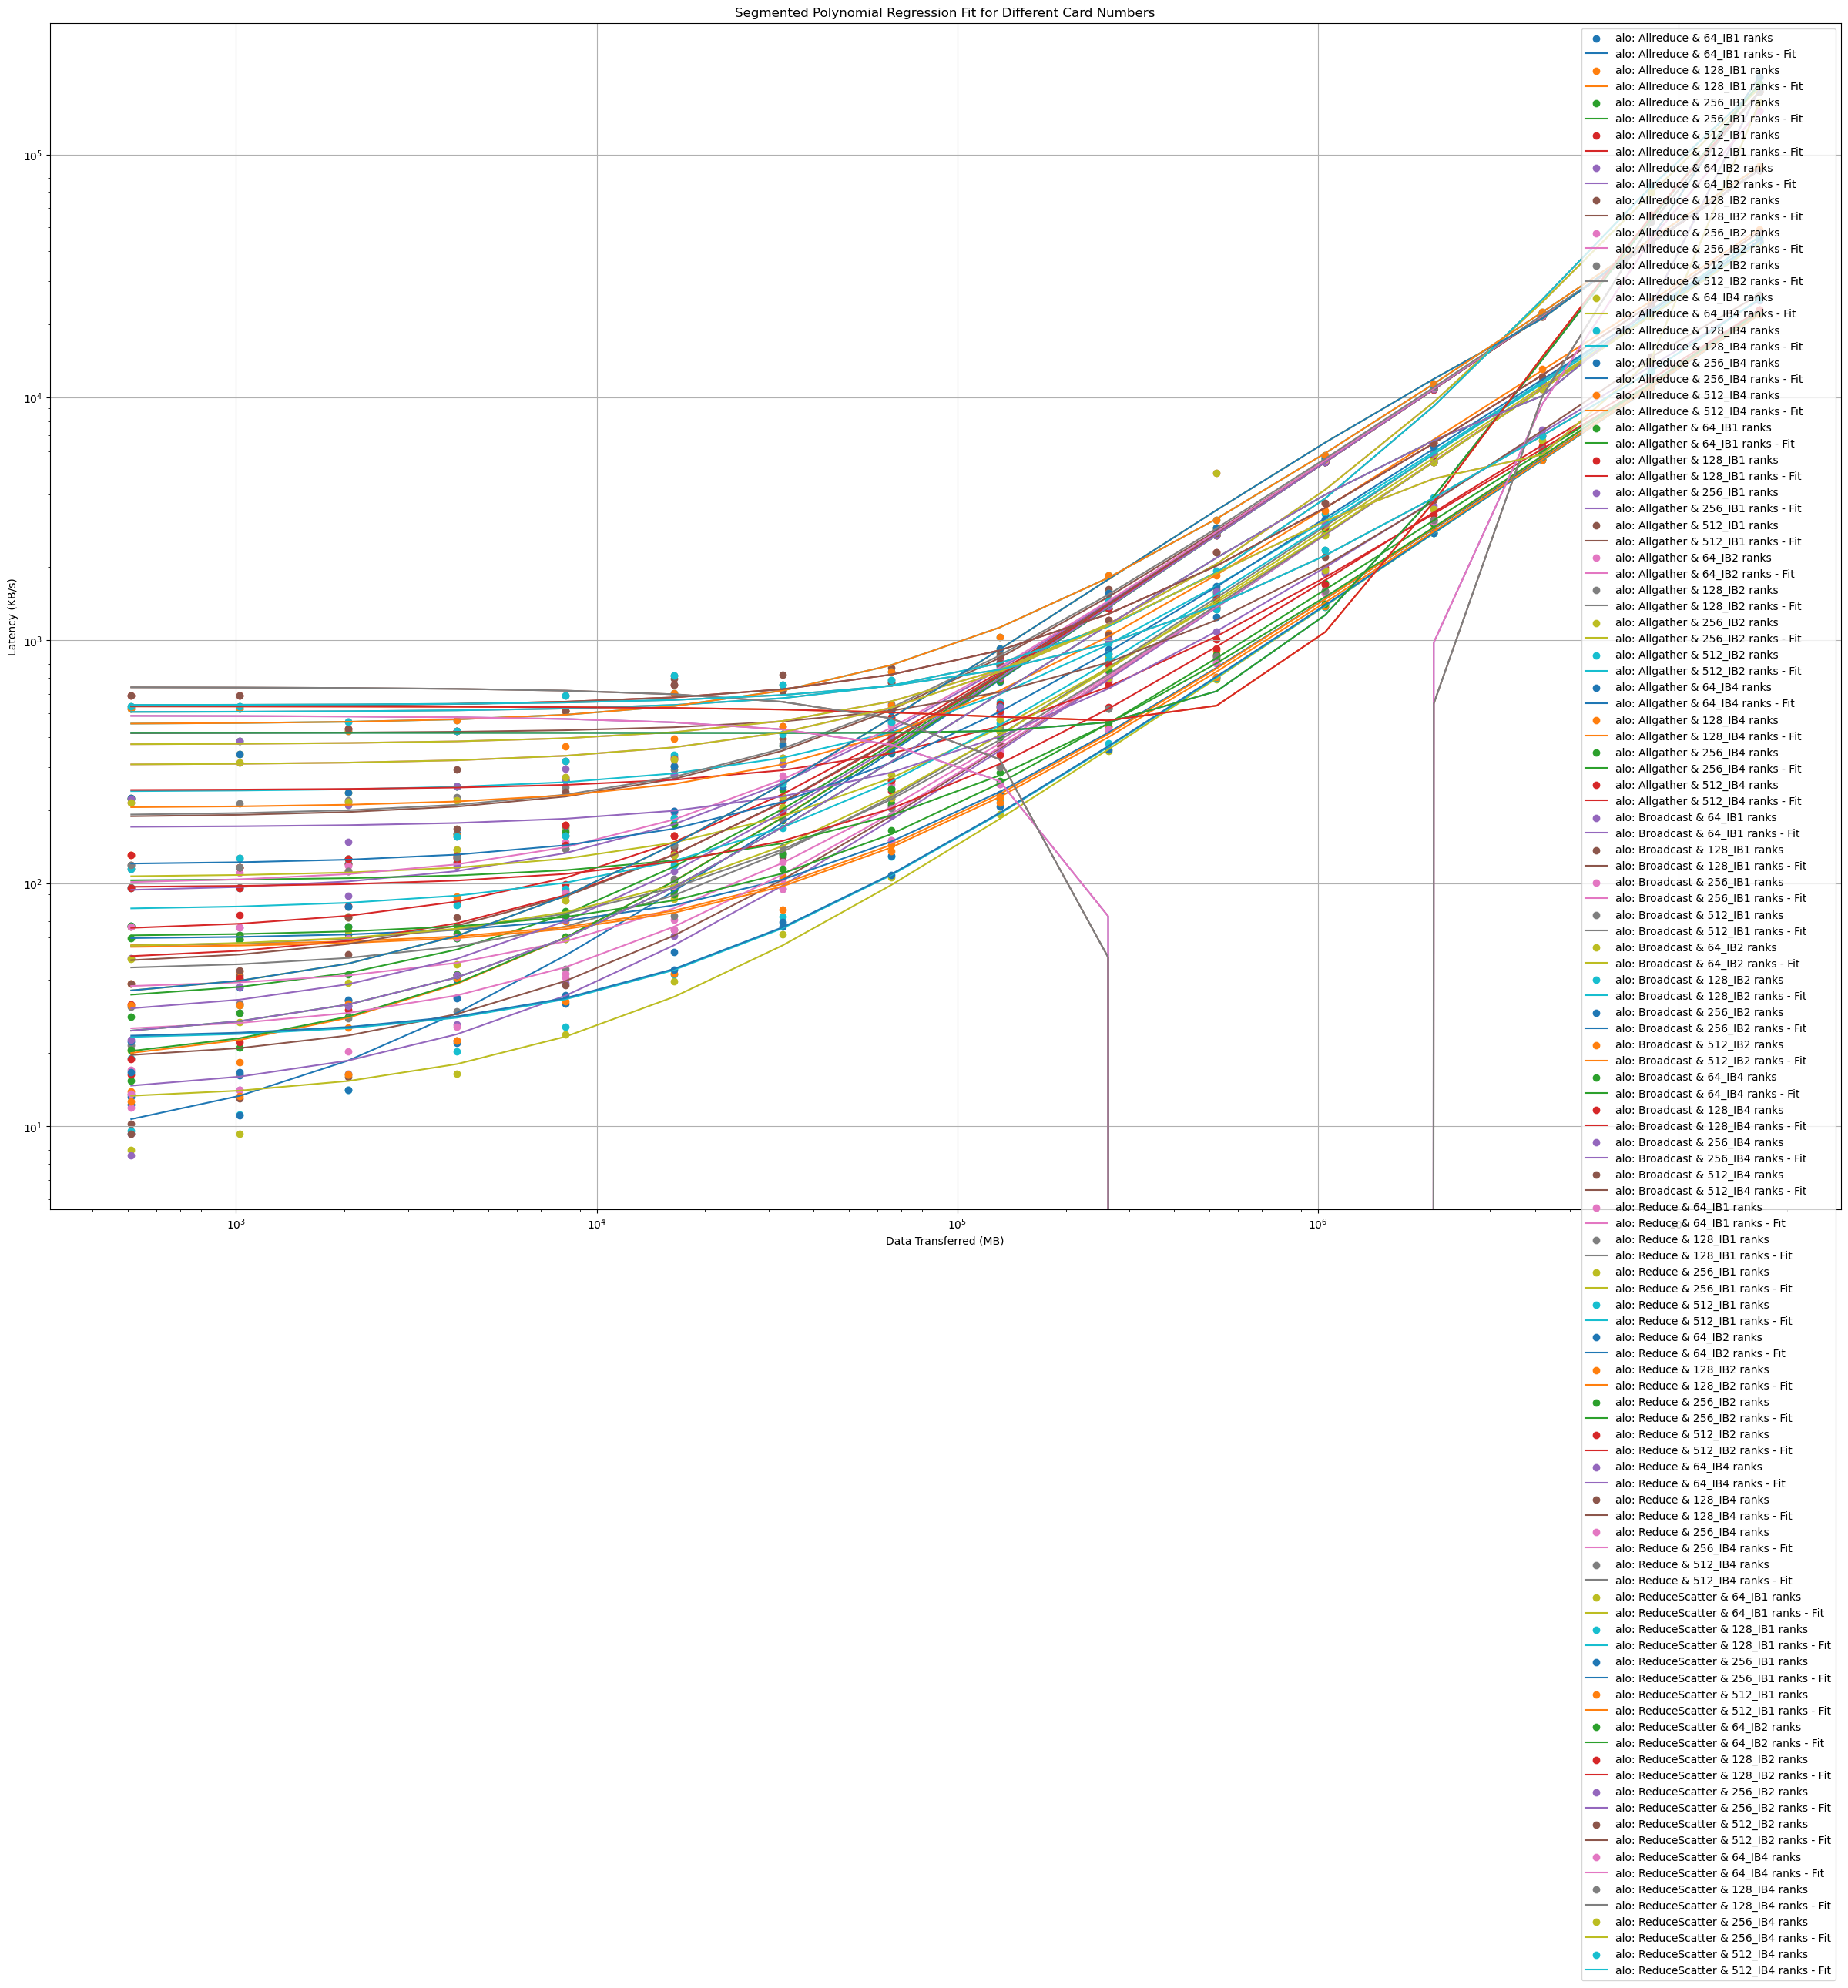

In [32]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import joblib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

# 可视化每个分段的拟合结果
plt.figure(figsize=(30, 20))

# Path to your Excel file
excel_path = './comm.xlsx'

# Read the Excel file
xls = pd.ExcelFile(excel_path)
ranks=[64,128,256,512]
IBs=['IB1','IB2','IB4']


models = {sheet_name: {rank: {ib: None for ib in IBs} for rank in ranks} for sheet_name in xls.sheet_names}

# Iterate through each sheet
for sheet_name in xls.sheet_names:
    # Read sheet into DataFrame
    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    
    gpu64_IB1=df.iloc[0,1:]
    gpu128_IB1=df.iloc[1,1:]
    gpu256_IB1=df.iloc[2,1:]
    gpu512_IB1=df.iloc[3,1:]

    gpu64_IB2=df.iloc[6,1:]
    gpu128_IB2=df.iloc[7,1:]
    gpu256_IB2=df.iloc[8,1:]
    gpu512_IB2=df.iloc[9,1:]

    gpu64_IB4=df.iloc[12,1:]
    gpu128_IB4=df.iloc[13,1:]
    gpu256_IB4=df.iloc[14,1:]
    gpu512_IB4=df.iloc[15,1:]

    data={
        'Data_MB':[512, 1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072, 262144, 524288, 1048576, 2097152, 4194304,
                8388608, 16777216],
        '64_IB1': gpu64_IB1,
        '128_IB1':gpu128_IB1,
        '256_IB1':gpu256_IB1,
        '512_IB1':gpu512_IB1,
        '64_IB2': gpu64_IB2,
        '128_IB2':gpu128_IB2,
        '256_IB2':gpu256_IB2,
        '512_IB2':gpu512_IB2,
        '64_IB4': gpu64_IB4,
        '128_IB4':gpu128_IB4,
        '256_IB4':gpu256_IB4,
        '512_IB4':gpu512_IB4,
    }
    for i in data:
        if i == 'Data_MB': continue
        
        y=np.array(data[i])
        X = np.array(data['Data_MB']).reshape(-1, 1)

        poly_features = PolynomialFeatures(degree=3, include_bias=False)
        X_poly = poly_features.fit_transform(X)

        # 从之前的模型中获取预测值
        model = LinearRegression().fit(X_poly, y)
        y_pred = model.predict(X_poly)
        rank,ib = int(i.split('_')[0]),i.split('_')[1]

        models[sheet_name][rank][ib] = model
        joblib.dump(model, f'comm/{sheet_name}_{rank}_{ib}_model.joblib')

        # 绘制散点图和拟合曲线
        plt.scatter(X, y, label=f'alo: {sheet_name} & {i} ranks')
        plt.plot(X, y_pred, label=f'alo: {sheet_name} & {i} ranks - Fit')

    # Assuming the first column is the target variable and the rest are features
plt.xlabel('Data Transferred (MB)')
plt.ylabel('Latency (KB/s)')
plt.title('Segmented Polynomial Regression Fit for Different Card Numbers')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()




In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import joblib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

data_volume=150*1024
poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_pred = poly_features.fit_transform([[data_volume]])
comm_alo='Allgather'
rank=256
ib='IB4'
model=joblib.load(f'comm/{comm_alo}_{rank}_{ib}_model.joblib')
predictions = model.predict(X_pred)

